# Conceptualization
* This component takes two CSV files as input
* Those CSV can be generated from a excel file, a SQL or non-SQL database, a power BI enviroment, and so forth

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10000000)

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

FLAG_EXPORT = False

In [2]:
raw1 = pd.read_csv ("../../datasets/brasilia_case_climatic.csv", header=0)
raw1.head()

,timestamp,temp_celsius,pression,precipitation,windspeed_mps
0,2018-01-31 00:00:00-02,21,1011.7,0.0,1.2
1,2018-01-31 01:00:00-02,21,1011.5,0.0,1.5
2,2018-01-31 02:00:00-02,20,1011.0,0.0,1.8
3,2018-01-31 03:00:00-02,20,1010.2,0.0,1.7
4,2018-01-31 04:00:00-02,20,1009.9,0.0,1.8


In [3]:
raw1.describe()

,temp_celsius,pression,precipitation,windspeed_mps
count,16365.000000,16365.000000,16365.000000,16365.000000
mean,21.709502,1015.286227,0.093981,2.228555
std,3.870892,3.177252,0.504643,1.040920
min,10.000000,1005.100000,0.000000,0.000000
25%,19.000000,1013.100000,0.000000,1.500000
50%,21.000000,1015.100000,0.000000,2.000000
75%,24.000000,1017.400000,0.000000,2.800000
max,34.000000,1026.300000,18.000000,7.900000


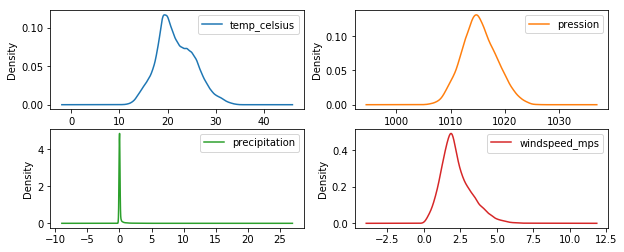

In [4]:
raw1.plot.kde(subplots=True, sharex=False, figsize=(10,4), layout=(2,2))
if FLAG_EXPORT: plt.savefig('graph_kde1.svg', format='svg')

In [5]:
raw1['timestamp'] = pd.to_datetime (raw1['timestamp'], utc=True)
raw1 = raw1.set_index(raw1.timestamp)
raw1 = raw1.drop ('timestamp', axis=1)

raw1 = raw1.set_index(raw1.index.tz_convert(None) + pd.offsets.Hour(-2)) # correct to brazilian timezone

In [6]:
filtered1 = raw1.resample('10min').interpolate(method='akima', limit_area='inside')

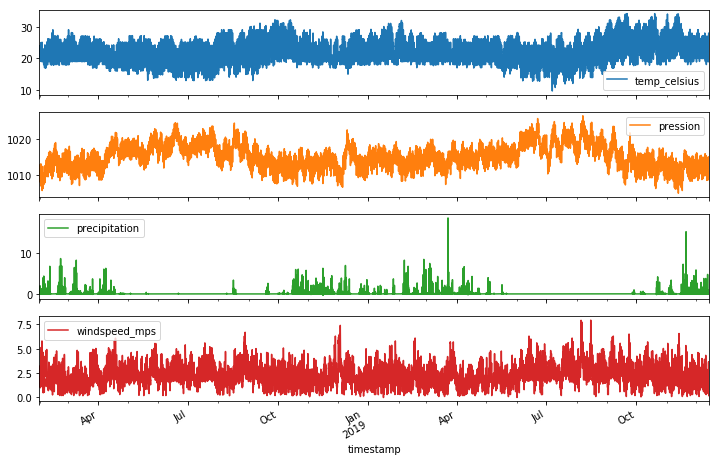

In [7]:
Axis = filtered1.plot(subplots=True, sharex=True, figsize=(12,8))


# Electrical database exploration
* Convert index to timestamp
* Resample by hour
* Calculates load factor

In [8]:
raw2 = pd.read_csv ("../../datasets/brasilia_case_electric.csv", header=0)
raw2.describe()

,p3,s3,cosphi,voltage,month,hour,dayofweek
count,857147.000000,857147.000000,857147.000000,857147.000000,987841.000000,987841.000000,987841.000000
mean,183.425452,188.216562,0.953158,223.184563,6.672017,11.499988,3.000001
std,155.860108,155.022113,0.032707,2.766074,3.268192,6.922196,2.000000
min,48.737500,53.590995,0.830174,208.966000,1.000000,0.000000,0.000000
25%,74.080833,80.127747,0.925084,221.431000,4.000000,5.000000,1.000000
50%,89.919167,95.665319,0.946635,223.134667,7.000000,11.000000,3.000000
75%,287.483155,289.455420,0.990457,224.994306,9.000000,17.000000,5.000000
max,713.428333,719.000686,0.999890,237.393444,12.000000,23.000000,6.000000


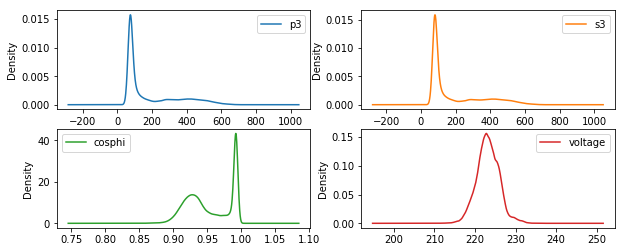

In [9]:
raw2[['p3', 's3', 'cosphi', 'voltage']].plot.kde(subplots=True, sharex=False, figsize=(10,4), layout=(2,2))
if FLAG_EXPORT: plt.savefig('graph_kde2.svg', format='svg')

In [10]:
raw2['timestamp'] = pd.to_datetime (raw2['timestamp']) # already was in brazilian timezone
raw2 = raw2.set_index(raw2.timestamp)
raw2 = raw2.drop ('timestamp', axis=1)

In [11]:
# Resample
resampled2 = raw2.resample('10min').agg({
    'voltage': ['mean', 'count'],
    'cosphi': ['mean', 'std'],
    'month': ['mean'],
    'hour': ['mean'],
    'dayofweek': ['mean'],
    'p3': ['mean', 'max', 'std']
})

resampled2.columns = resampled2.columns.map('_'.join)
resampled2 = resampled2.dropna()
#resampled2.plot(subplots=True)


In [12]:
filtered2 = resampled2[(resampled2['voltage_count'] == 10)]
filtered2 = filtered2.drop('voltage_count', axis=1)

In [13]:
filtered2['load_factor'] = filtered2['p3_mean']/filtered2['p3_max']

In [14]:
filtered2 = filtered2.drop('p3_max', axis=1)

In [15]:
filtered2.head()

,voltage_mean,cosphi_mean,cosphi_std,month_mean,hour_mean,dayofweek_mean,p3_mean,p3_std,load_factor
timestamp,,,,,,,,,
2018-02-01 00:00:00,222.422553,0.931323,0.003132,2,0,4,76.384250,2.901398,0.936588
2018-02-01 00:10:00,221.822300,0.938584,0.003327,2,0,4,79.409299,4.679058,0.916590
2018-02-01 00:20:00,222.539326,0.933304,0.004393,2,0,4,74.200246,3.366907,0.950006
2018-02-01 00:30:00,222.744070,0.934903,0.005175,2,0,4,76.059915,2.742411,0.949632
2018-02-01 00:40:00,222.832179,0.936927,0.003765,2,0,4,77.216275,2.191767,0.963748


# Data integration
* if precipitation<0: precipitation=0

In [28]:
merged = pd.merge (filtered1, filtered2,how='inner', left_index=True, right_index=True).astype('float')


In [29]:
merged.loc[merged['precipitation']<0, 'precipitation']=0

In [30]:
merged.describe()

,temp_celsius,pression,precipitation,windspeed_mps,voltage_mean,cosphi_mean,cosphi_std,month_mean,hour_mean,dayofweek_mean,p3_mean,p3_std,load_factor
count,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000
mean,21.606721,1015.557561,0.078827,2.249271,223.184579,0.953134,0.002702,6.204814,11.535972,3.022961,183.422097,5.503859,0.948770
std,3.867777,3.109658,0.441904,1.035418,2.747639,0.032593,0.002173,3.113732,6.925896,1.982185,155.619762,4.543470,0.025153
min,9.600000,1005.700000,0.000000,-0.006346,210.030339,0.853330,0.000076,1.000000,0.000000,0.000000,52.673333,0.424814,0.641996
25%,19.000000,1013.433333,0.000000,1.546958,221.439586,0.924797,0.000692,4.000000,6.000000,1.000000,74.133104,2.722198,0.935813
50%,21.000000,1015.416847,0.000000,2.048691,223.130786,0.946207,0.002361,6.000000,12.000000,3.000000,89.419042,4.055262,0.953135
75%,24.333333,1017.644544,0.000000,2.803172,224.990057,0.990512,0.004066,9.000000,18.000000,5.000000,287.467708,6.948134,0.966622
max,34.187500,1026.300000,18.687395,7.938492,236.857867,0.997968,0.026059,12.000000,23.000000,6.000000,692.232000,81.669494,0.995246


In [31]:
merged.describe()
# sobraram 84926 pontos, de potenciais 686*24*60/10=98784

,temp_celsius,pression,precipitation,windspeed_mps,voltage_mean,cosphi_mean,cosphi_std,month_mean,hour_mean,dayofweek_mean,p3_mean,p3_std,load_factor
count,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000
mean,21.606721,1015.557561,0.078827,2.249271,223.184579,0.953134,0.002702,6.204814,11.535972,3.022961,183.422097,5.503859,0.948770
std,3.867777,3.109658,0.441904,1.035418,2.747639,0.032593,0.002173,3.113732,6.925896,1.982185,155.619762,4.543470,0.025153
min,9.600000,1005.700000,0.000000,-0.006346,210.030339,0.853330,0.000076,1.000000,0.000000,0.000000,52.673333,0.424814,0.641996
25%,19.000000,1013.433333,0.000000,1.546958,221.439586,0.924797,0.000692,4.000000,6.000000,1.000000,74.133104,2.722198,0.935813
50%,21.000000,1015.416847,0.000000,2.048691,223.130786,0.946207,0.002361,6.000000,12.000000,3.000000,89.419042,4.055262,0.953135
75%,24.333333,1017.644544,0.000000,2.803172,224.990057,0.990512,0.004066,9.000000,18.000000,5.000000,287.467708,6.948134,0.966622
max,34.187500,1026.300000,18.687395,7.938492,236.857867,0.997968,0.026059,12.000000,23.000000,6.000000,692.232000,81.669494,0.995246


In [32]:
merged.describe()

,temp_celsius,pression,precipitation,windspeed_mps,voltage_mean,cosphi_mean,cosphi_std,month_mean,hour_mean,dayofweek_mean,p3_mean,p3_std,load_factor
count,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000,84926.000000
mean,21.606721,1015.557561,0.078827,2.249271,223.184579,0.953134,0.002702,6.204814,11.535972,3.022961,183.422097,5.503859,0.948770
std,3.867777,3.109658,0.441904,1.035418,2.747639,0.032593,0.002173,3.113732,6.925896,1.982185,155.619762,4.543470,0.025153
min,9.600000,1005.700000,0.000000,-0.006346,210.030339,0.853330,0.000076,1.000000,0.000000,0.000000,52.673333,0.424814,0.641996
25%,19.000000,1013.433333,0.000000,1.546958,221.439586,0.924797,0.000692,4.000000,6.000000,1.000000,74.133104,2.722198,0.935813
50%,21.000000,1015.416847,0.000000,2.048691,223.130786,0.946207,0.002361,6.000000,12.000000,3.000000,89.419042,4.055262,0.953135
75%,24.333333,1017.644544,0.000000,2.803172,224.990057,0.990512,0.004066,9.000000,18.000000,5.000000,287.467708,6.948134,0.966622
max,34.187500,1026.300000,18.687395,7.938492,236.857867,0.997968,0.026059,12.000000,23.000000,6.000000,692.232000,81.669494,0.995246


In [33]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84926 entries, 2018-02-01 00:00:00 to 2019-12-13 23:00:00
Data columns (total 13 columns):
temp_celsius      84926 non-null float64
pression          84926 non-null float64
precipitation     84926 non-null float64
windspeed_mps     84926 non-null float64
voltage_mean      84926 non-null float64
cosphi_mean       84926 non-null float64
cosphi_std        84926 non-null float64
month_mean        84926 non-null float64
hour_mean         84926 non-null float64
dayofweek_mean    84926 non-null float64
p3_mean           84926 non-null float64
p3_std            84926 non-null float64
load_factor       84926 non-null float64
dtypes: float64(13)
memory usage: 9.1 MB


In [34]:
#merged.iloc[0]['month_mean']=3
#merged.iloc[0]['dayofweek_mean']=3
#TODO: remove this zero-std workarround

X = merged.drop('p3_mean', axis=1)
y = merged ['p3_mean']

X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X = (X - X_mean) / X_std

merged = pd.merge (X, y, how='inner', left_index=True, right_index=True)

# Output
* 2 anos de medições em Brasilia, bloco C
* Variables:
  * temperature (float, interpolated. Unit: celsius)
  * pressure (float, interpolated. Unit: hPa)
  * precipitation (float, interpolated. Unit: mm)
  * windspeed (float, interpolated. Unit: mps)
  * voltage (float. Unit: Volts)
  * cos_phi (float $\in [0,1]$. Unit: none)
  * cos_phi_std (float. Unit: none)
  * load_factor (float. Unit: none)
  * month (Int $\in [1,12]$)
  * day_of_week (Int $\in [0,6]$)
  * hour (Int $\in [0,23]$)
  * p3 (Float. Unit: KW)

* Agregados a cada... 10min
* to esperando uns 85MB (10min)


In [35]:
merged = merged.rename(columns={
    'temp_celsius': 'temperature', 
    'pression': 'pressure', 
    'precipitation': 'precipitation', 
    'windspeed_mps': 'windspeed', 
    'voltage_mean': 'voltage',
    'cosphi_mean': 'cos_phi', 
    'cosphi_std': 'cos_phi_std', 
    'load_factor': 'load_factor', 
    'month_mean': 'month', 
    'dayofweek_mean': 'day_of_week', 
    'hour_mean': 'hour', 
    'p3_std': 'p3_std',
    'p3_mean': 'p3'
})

In [36]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84926 entries, 2018-02-01 00:00:00 to 2019-12-13 23:00:00
Data columns (total 13 columns):
temperature      84926 non-null float64
pressure         84926 non-null float64
precipitation    84926 non-null float64
windspeed        84926 non-null float64
voltage          84926 non-null float64
cos_phi          84926 non-null float64
cos_phi_std      84926 non-null float64
month            84926 non-null float64
hour             84926 non-null float64
day_of_week      84926 non-null float64
p3_std           84926 non-null float64
load_factor      84926 non-null float64
p3               84926 non-null float64
dtypes: float64(13)
memory usage: 9.1 MB


In [37]:
merged.describe()

,temperature,pressure,precipitation,windspeed,voltage,cos_phi,cos_phi_std,month,hour,day_of_week,p3_std,load_factor,p3
count,8.492600e+04,8.492600e+04,8.492600e+04,8.492600e+04,8.492600e+04,8.492600e+04,8.492600e+04,8.492600e+04,8.492600e+04,8.492600e+04,8.492600e+04,8.492600e+04,84926.000000
mean,-3.402868e-14,-5.765384e-13,9.578095e-16,2.717207e-14,9.715281e-13,-6.012313e-14,-4.310478e-16,-9.638335e-17,1.157102e-16,2.108386e-17,7.107603e-15,1.497101e-13,183.422097
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,155.619762
min,-3.104314e+00,-3.170001e+00,-1.783818e-01,-2.178473e+00,-4.787499e+00,-3.062172e+00,-1.209125e+00,-1.671578e+00,-1.665639e+00,-1.525074e+00,-1.117884e+00,-1.219653e+01,52.673333
25%,-6.739626e-01,-6.831105e-01,-1.783818e-01,-6.782934e-01,-6.350920e-01,-8.694246e-01,-9.255688e-01,-7.080978e-01,-7.993197e-01,-1.020577e+00,-6.122363e-01,-5.151269e-01,74.133104
50%,-1.568666e-01,-4.525084e-02,-1.783818e-01,-1.937196e-01,-1.957806e-02,-2.125279e-01,-1.571318e-01,-6.577792e-02,6.699931e-02,-1.158383e-02,-3.188324e-01,1.735372e-01,89.419042
75%,7.049600e-01,6.711333e-01,-1.783818e-01,5.349571e-01,6.571054e-01,1.146815e+00,6.277824e-01,8.977019e-01,9.333183e-01,9.974096e-01,3.178812e-01,7.097525e-01,287.467708
max,3.252735e+00,3.454561e+00,4.211027e+01,5.494644e+00,4.976406e+00,1.375603e+00,1.075037e+01,1.861182e+00,1.655251e+00,1.501906e+00,1.676386e+01,1.847771e+00,692.232000


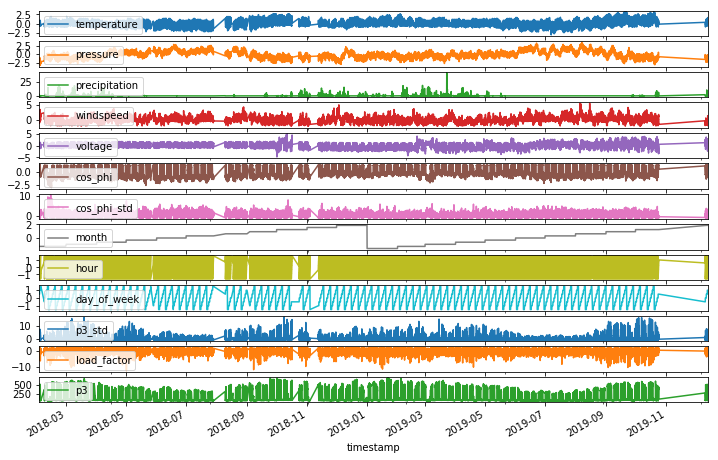

In [38]:
Axis = merged.plot(subplots=True, sharex=True, figsize=(12,8))
for k in range(0,merged.shape[1],1):
    Axis[k].legend(loc='upper left')
if FLAG_EXPORT: plt.savefig('graph_temporal.svg', format='svg')

In [39]:
merged.to_csv("../../datasets/brasilia_case_preprocessed.csv")